In [298]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import random, os
import seaborn as sns
from glob import glob 
from PIL import Image
import cv2
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report

In [299]:
#Import metadata 
df =pd.read_csv('HAM10000_metadata.csv')

## Simple EDA

In [300]:
df.head(25)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


Text(0.5, 1.0, 'Frequency Distribution of Classes')

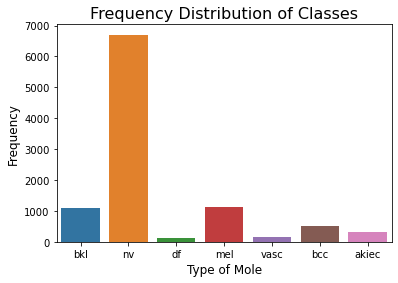

In [301]:
##Frequency distribution of classes:
sns.countplot(x = 'dx', data = df)
plt.xlabel('Type of Mole', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

In [302]:
path = "HAM10000_images/"

In [303]:
df.shape

(10015, 7)

In [304]:
#Check for duplicates in dataset and remove them

bool_series = df['lesion_id'].duplicated()
bool_series.sum()

2545

In [305]:
#Removing duplicated 
df.drop_duplicates(subset ="lesion_id",
                     keep = "first", inplace = True)

In [306]:
df.shape

(7470, 7)

Text(0.5, 1.0, 'Frequency Distribution of Classes')

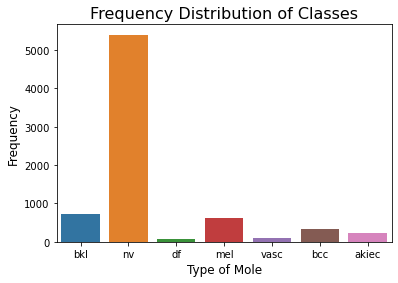

In [307]:
##Frequency distribution of classes after dropping duplicates:
sns.countplot(x = 'dx', data = df)
plt.xlabel('Type of Mole', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

In [308]:
#Adding name of image to dataset
df["image_name"] = df['image_id']+ '.jpg'
X = df[["image_name",'dx', 'lesion_id']]
y = X.pop('dx').to_frame()

In [309]:
X.sample(5)

,image_name,lesion_id
2872,ISIC_0031407.jpg,HAM_0001575
10001,ISIC_0031922.jpg,HAM_0000020
9599,ISIC_0033751.jpg,HAM_0005257
3260,ISIC_0029943.jpg,HAM_0002632
531,ISIC_0029031.jpg,HAM_0004143


In [310]:
y.value_counts()

dx   
nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
df         73
dtype: int64

### Undersampling for imbalanced dataset

In [311]:
#undersample = RandomUnderSampler(sampling_strategy='majority')
sampling_strategy = {'bkl': 600, 'nv':2000 , 'df': 73, 'mel':500 , 'vasc':98 , 'bcc':327 , 'akiec':228 }
#undersample = RandomUnderSampler(sampling_strategy='majority')
undersample = RandomUnderSampler(sampling_strategy= sampling_strategy)
X,y  = undersample.fit_resample(X,y)

In [312]:
X.shape

(3826, 2)

Text(0.5, 1.0, 'Frequency Distribution of Classes')

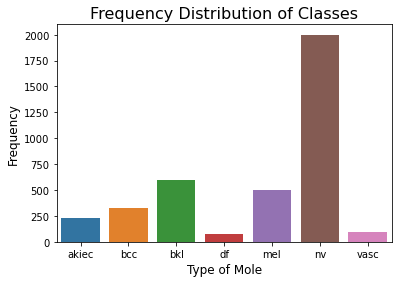

In [313]:
sns.countplot(x = 'dx', data = y)
plt.xlabel('Type of Mole', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

In [345]:
#Splitting dataset
#Reference https://www.youtube.com/watch?v=nuakBf3rBmw, https://www.kaggle.com/code/dhruv1234/ham10000-skin-disease-classification/notebook

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)

In [315]:
train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_train, y_train], axis=1)

In [316]:
train.head()

,image_name,lesion_id,dx
3148,ISIC_0026910.jpg,HAM_0003661,nv
3153,ISIC_0034278.jpg,HAM_0004375,nv
885,ISIC_0031223.jpg,HAM_0002456,bkl
2097,ISIC_0028300.jpg,HAM_0004092,nv
3561,ISIC_0027683.jpg,HAM_0005738,nv


In [317]:
encoder = LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_train = encoder.transform(val['dx'])
val['label'] = name_as_indexes_train

In [318]:
val.head()

,image_name,lesion_id,dx,label
3390,ISIC_0034248.jpg,HAM_0004214,nv,5
532,ISIC_0027976.jpg,HAM_0004342,bcc,1
737,ISIC_0027612.jpg,HAM_0001990,bkl,2
1560,ISIC_0031561.jpg,HAM_0006744,mel,4
3511,ISIC_0025486.jpg,HAM_0006784,nv,5


In [319]:
encoder = LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test = encoder.transform(test['dx'])
test['label'] = name_as_indexes_test

In [320]:
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range = 10, 
                                     zoom_range = 0.1,
                                     width_shift_range=0.0, height_shift_range=0.00
)
#train_generator = ImageDataGenerator(rescale = 1./255)

In [321]:
train_data = train_generator.flow_from_dataframe(dataframe=train, x_col='image_name', y_col="dx", batch_size=32, directory=path, shuffle =True, class_mode="categorical", target_size=(224,224))
#train_generator.fit(X_train)

Found 2448 validated image filenames belonging to 7 classes.


In [322]:
train_data.image_shape

(224, 224, 3)

In [323]:
test_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range = 10, 
                                     zoom_range = 0.1,
                                     width_shift_range=0.0, height_shift_range=0.02
)
#test_generator = ImageDataGenerator(rescale = 1./255)

In [324]:
test_data = test_generator.flow_from_dataframe(dataframe=test, x_col='image_name', y_col="dx", batch_size=1, directory=path, shuffle=False, class_mode=None, target_size=(224,224))

Found 2448 validated image filenames.


In [325]:
test_data.image_shape

(224, 224, 3)

In [326]:
val_data = test_generator.flow_from_dataframe(dataframe=val, x_col='image_name', y_col="dx", batch_size=64, directory=path, shuffle=False, class_mode="categorical", target_size=(224,224))

Found 612 validated image filenames belonging to 7 classes.


In [327]:
val_data.image_shape

(224, 224, 3)

### Showcase some of the training images

In [328]:
def plot_images(img_array):
    fig, axes = plt.subplots(1,5, figsize=(25,25))
    axes = axes.flatten()
    for img, ax in zip(img_array,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

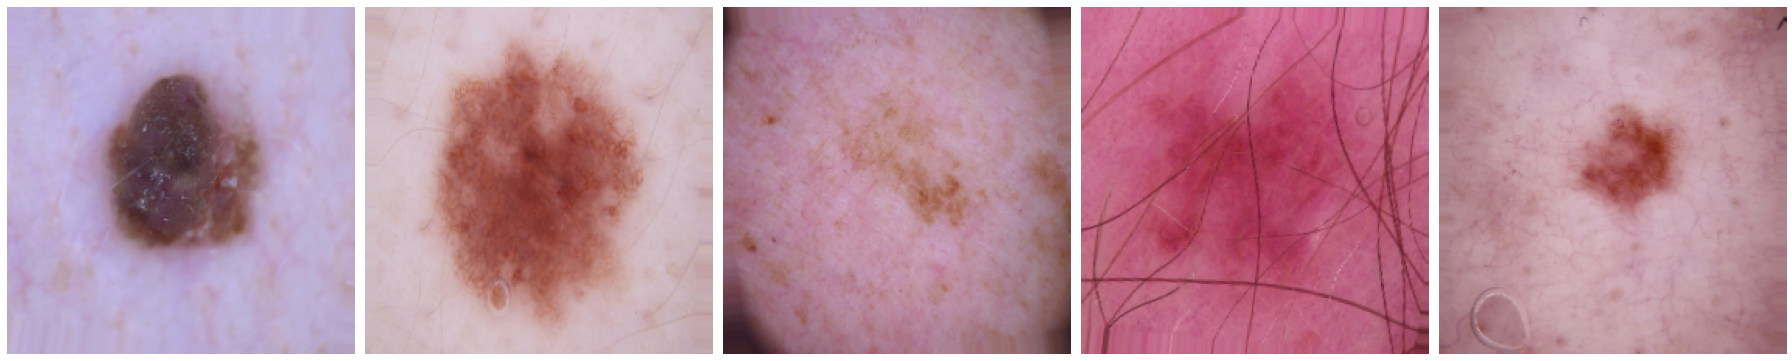

In [329]:
sample_train_images, _ = next(train_data)
plot_images(sample_train_images[:5])

In [330]:
#Using model
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
# for layer in model.layers:
#     layer.trainable = False

In [331]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(16,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
#model.add(Dropout(0.4))
#Output layer must match the different outputs from our labels, in this case 7
model.add(Dense(7,activation='sigmoid'))

In [332]:
#learning_control = ReduceLROnPlateau(monitor='val_acc',patience=3, verbose=1, factor=.5, min_lr=0.0001)

In [333]:
#Defining metrics
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [334]:
sgd = SGD(learning_rate=0.01,clipvalue=0.5)
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=METRICS)

In [335]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 16)          184336    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 16)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 7)                

In [336]:
history=model.fit(train_data,batch_size=128, epochs=5, validation_data=val_data)

Epoch 1/5
77/77 [==============================] - 252s 3s/step - loss: 1.2623 - tp: 2167.0000 - fp: 6296.0000 - tn: 8392.0000 - fn: 281.0000 - accuracy: 0.5719 - precision: 0.2561 - recall: 0.8852 - auc: 0.8424 - prc: 0.5744 - val_loss: 2.7897 - val_tp: 428.0000 - val_fp: 874.0000 - val_tn: 2798.0000 - val_fn: 184.0000 - val_accuracy: 0.5310 - val_precision: 0.3287 - val_recall: 0.6993 - val_auc: 0.7959 - val_prc: 0.4280
Epoch 2/5
77/77 [==============================] - 242s 3s/step - loss: 0.9344 - tp: 2316.0000 - fp: 6086.0000 - tn: 8602.0000 - fn: 132.0000 - accuracy: 0.6552 - precision: 0.2756 - recall: 0.9461 - auc: 0.8999 - prc: 0.6944 - val_loss: 3.2631 - val_tp: 433.0000 - val_fp: 931.0000 - val_tn: 2741.0000 - val_fn: 179.0000 - val_accuracy: 0.5310 - val_precision: 0.3174 - val_recall: 0.7075 - val_auc: 0.7758 - val_prc: 0.4181
Epoch 3/5
77/77 [==============================] - 255s 3s/step - loss: 0.7764 - tp: 2358.0000 - fp: 5697.0000 - tn: 8991.0000 - fn: 90.0000 - accur

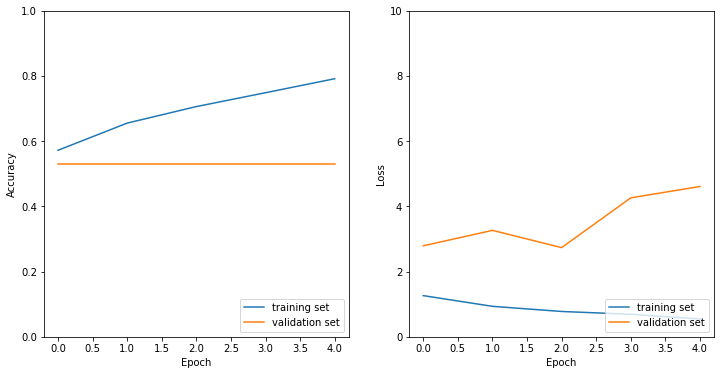

In [341]:
import tensorflow

def plot_history(history):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your `fit` method to plot the loss and accuracy of
    the training and validation set.
    """
    
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    #plt.title("Model Accuracy")
    #axs[0].plt.title('Model Accuracy')
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0, 1])
    
    #plt.title("Model Loss")
    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 10])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')
    
plot_history(history)

In [347]:
#loss, acc = model.evaluate(test_data, verbose=0)
model.evaluate(test_data, verbose=0)
# print('Test accuracy: ', score)
# print('Test loss:', loss)
# print('Test accuracy:', acc)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [350]:
history.history

{'loss': [1.262285828590393,
  0.934351921081543,
  0.7763888239860535,
  0.691415011882782,
  0.5463621020317078],
 'tp': [2167.0, 2316.0, 2358.0, 2381.0, 2415.0],
 'fp': [6296.0, 6086.0, 5697.0, 6037.0, 5977.0],
 'tn': [8392.0, 8602.0, 8991.0, 8651.0, 8711.0],
 'fn': [281.0, 132.0, 90.0, 67.0, 33.0],
 'accuracy': [0.5718954205513,
  0.6552287340164185,
  0.7058823704719543,
  0.7483659982681274,
  0.7912581562995911],
 'precision': [0.2560557723045349,
  0.27564865350723267,
  0.2927374243736267,
  0.28284627199172974,
  0.28777405619621277],
 'recall': [0.8852124214172363,
  0.9460784196853638,
  0.9632353186607361,
  0.9726307392120361,
  0.9865196347236633],
 'auc': [0.84241783618927,
  0.8999214768409729,
  0.9215404987335205,
  0.9303820729255676,
  0.9455933570861816],
 'prc': [0.5744296908378601,
  0.6944122314453125,
  0.7226075530052185,
  0.7317376732826233,
  0.7671859860420227],
 'val_loss': [2.7897205352783203,
  3.2631430625915527,
  2.7344810962677,
  4.26061487197876,

In [348]:
model.save('./model/my_model.h5')

In [96]:
# Dictionary with different classes of moles:
#Reference: https://www.kaggle.com/code/dhruv1234/ham10000-skin-disease-classification/notebook
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}

### Predicting Class Type

ISIC_0033675.jpg


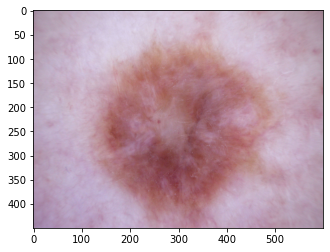

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0028468.jpg


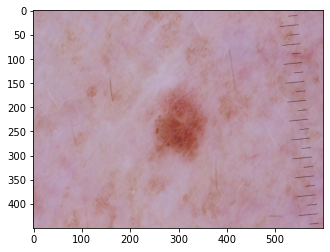

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0027670.jpg


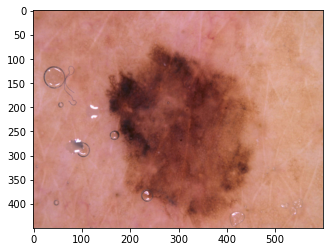

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0033632.jpg


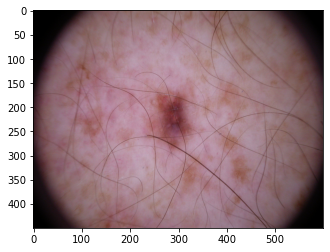

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0024776.jpg


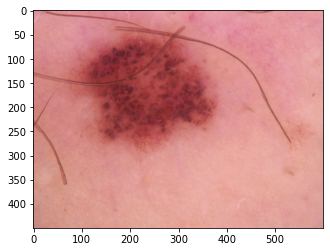

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0032718.jpg


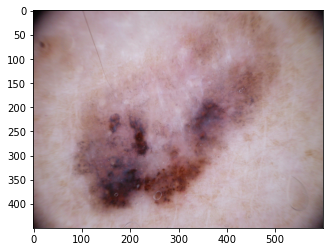

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0027879.jpg


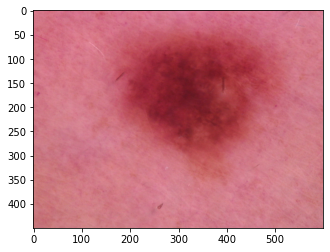

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0029409.jpg


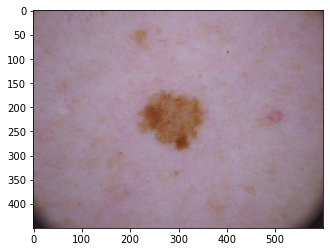

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0028837.jpg


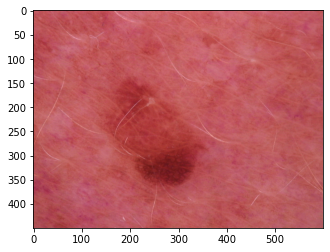

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0032226.jpg


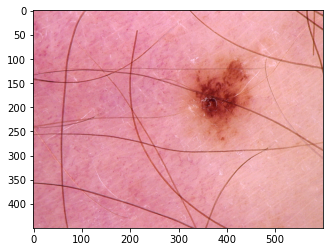

('vasc', ' pyogenic granulomas and hemorrhage')


In [358]:
# sdir=r'drive/My Drive/HAZIQ/TESTTEST/MODELTEST/'
# flist=os.listdir(sdir)
# test_img=random.choice(flist)
# test_img=os.path.join(sdir, test_img)

for temp in range(0,10):
    img_name = random.choice(os.listdir(path))
    print(img_name)
#     img = random.choice([
#         x for x in os.listdir(path)
#         if os.path.isfile(os.path.join(path, x))
#         ])
 
    img = cv2.imread(os.path.join(path, img_name))
    #cv2.imwrite(temp, img)
    #cv2.imshow(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    img = cv2.resize(img, (224, 224))
    result = model.predict(img.reshape(1, 224, 224, 3))
    max_prob = max(result[0])
    class_ind = list(result[0]).index(max_prob)
    class_name = classes[class_ind]
    print(class_name)
    

In [235]:
list_img=os.listdir(path)[:10]
list_img

['ISIC_0024306.jpg',
 'ISIC_0024307.jpg',
 'ISIC_0024308.jpg',
 'ISIC_0024309.jpg',
 'ISIC_0024310.jpg',
 'ISIC_0024311.jpg',
 'ISIC_0024312.jpg',
 'ISIC_0024313.jpg',
 'ISIC_0024314.jpg',
 'ISIC_0024315.jpg']

In [238]:
img_name = random.choice(list_img)
img_name

'ISIC_0024311.jpg'